The aim is to predict success rate (%) in reaching the Mount Rainier peak given (1) the route and (2) the weather condition.

Data from [Kaggle - Mount Rainier Weather and Climbing Data](https://www.kaggle.com/codersree/mount-rainier-weather-and-climbing-data).

# Import Libraries

In [59]:
# Load libraries
import sys
import scipy
import numpy as np
import pandas as pd
from pandas import read_csv
from pandas.plotting import scatter_matrix
from math import sqrt
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pickle

In [60]:
# get working directory
! pwd

/Users/ZoeHorlacher/Desktop/Ubiqum/C5_My own project/Climbing Mount Rainier


# Load dataset

In [62]:
# load data
climbing_data = pd.read_csv('climbing_statistics.csv')
weather_data = pd.read_csv('Rainier_Weather.csv')

## Preliminary exploration

In [63]:
climbing_data.info()
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4077 entries, 0 to 4076
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                4077 non-null   object 
 1   Route               4077 non-null   object 
 2   Attempted           4077 non-null   int64  
 3   Succeeded           4077 non-null   int64  
 4   Success Percentage  4077 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 159.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464 entries, 0 to 463
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   464 non-null    object 
 1   Battery Voltage AVG    464 non-null    float64
 2   Temperature AVG        464 non-null    float64
 3   Relative Humidity AVG  464 non-null    float64
 4   Wind Speed Daily AVG   464 non-null    float64
 5   Wind Direction

Merge the climbing and weather datasets into 1 dataset.

# Preprocess Data (1)

**Ways data can be preprocessed:**
* Remove missing values
* Remove outliers
* Remove duplicates
* Feature selection
* Feature engineering
* Feature scaling
    * **Numerical** data = standardize or normalize
    * **Categorical** data = one-hot encoding or dummify
* Group data into clusters
    * Cluster by an attribute (e.g. age, price)
    * Cluster using k-means

In [64]:
# Merge 2 datasets
joined_data = pd.merge(climbing_data, weather_data, how="left", on=["Date"])
joined_data.head()

,Date,Route,Attempted,Succeeded,Success Percentage,Battery Voltage AVG,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solare Radiation AVG
0,11/27/2015,Disappointment Cleaver,2,0,0.0,13.643750,26.321667,19.715000,27.839583,68.004167,88.496250
1,11/21/2015,Disappointment Cleaver,3,0,0.0,13.749583,31.300000,21.690708,2.245833,117.549667,93.660417
2,10/15/2015,Disappointment Cleaver,2,0,0.0,13.461250,46.447917,27.211250,17.163625,259.121375,138.387000
3,10/13/2015,Little Tahoma,8,0,0.0,13.532083,40.979583,28.335708,19.591167,279.779167,176.382667
4,10/9/2015,Disappointment Cleaver,2,0,0.0,13.216250,38.260417,74.329167,65.138333,264.687500,27.791292


In [65]:
# Remove missing values
joined_data.isna().sum()
joined_data = joined_data.dropna()
joined_data.isna().sum()

Date                     0
Route                    0
Attempted                0
Succeeded                0
Success Percentage       0
Battery Voltage AVG      0
Temperature AVG          0
Relative Humidity AVG    0
Wind Speed Daily AVG     0
Wind Direction AVG       0
Solare Radiation AVG     0
dtype: int64

In [66]:
# Remove rows where success percentage > 1.00
joined_data = joined_data[joined_data['Success Percentage'] <= 1]  
joined_data.describe()

,Attempted,Succeeded,Success Percentage,Battery Voltage AVG,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solare Radiation AVG
count,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000
mean,5.364743,2.573319,0.450365,13.502626,40.710507,47.869871,10.488669,155.508006,261.448846
std,3.908629,3.354267,0.457832,0.070525,9.114892,22.157661,9.141712,91.095224,110.563545
min,1.000000,0.000000,0.000000,12.987917,6.834833,12.363500,0.000000,13.490000,0.000000
25%,2.000000,0.000000,0.000000,13.453333,33.376667,30.057083,4.410292,55.200917,220.184875
50%,3.000000,2.000000,0.416667,13.491250,40.049167,46.140417,7.274917,171.633375,304.605708
75%,9.000000,4.000000,1.000000,13.546250,48.628750,65.174167,14.657875,235.496667,351.973292
max,12.000000,12.000000,1.000000,13.794583,56.153750,100.000000,65.138333,280.383333,368.056083


In [67]:
# Feature selection
data = joined_data.drop(columns=["Date", "Attempted","Succeeded", "Battery Voltage AVG"])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1889 entries, 0 to 1897
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Route                  1889 non-null   object 
 1   Success Percentage     1889 non-null   float64
 2   Temperature AVG        1889 non-null   float64
 3   Relative Humidity AVG  1889 non-null   float64
 4   Wind Speed Daily AVG   1889 non-null   float64
 5   Wind Direction AVG     1889 non-null   float64
 6   Solare Radiation AVG   1889 non-null   float64
dtypes: float64(6), object(1)
memory usage: 118.1+ KB


In [17]:
# dummify "Route"
dummy_Route = pd.get_dummies(data['Route'])
dummify_data = pd.concat([data, dummy_Route], axis = 1)
data = dummify_data.drop(columns=["Route"])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1889 entries, 0 to 1897
Data columns (total 28 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Success Percentage                1889 non-null   float64
 1   Temperature AVG                   1889 non-null   float64
 2   Relative Humidity AVG             1889 non-null   float64
 3   Wind Speed Daily AVG              1889 non-null   float64
 4   Wind Direction AVG                1889 non-null   float64
 5   Solare Radiation AVG              1889 non-null   float64
 6   Curtis RIngraham Directge         1889 non-null   uint8  
 7   Disappointment Cleaver            1889 non-null   uint8  
 8   Emmons-Winthrop                   1889 non-null   uint8  
 9   Fuhrer's Finger                   1889 non-null   uint8  
 10  Fuhrers Finger                    1889 non-null   uint8  
 11  Gibralter Chute                   1889 non-null   uint8  
 12  Gibral

In [10]:
# Alternative to dummify, is to code "Route"

# Change route into codes
data["Route"] = data["Route"].astype("category")
data["Route_code"] = data["Route"].cat.codes
data["Route_code"].describe() # if min is -1, then there is NA

# double check there are same no of unique Route names and Route codes
data["Route"].describe() == data["Route"].cat.codes.astype("category").describe()

# View Route code dictionary
code = data["Route"].astype('category')
code_dictionary = dict(enumerate(code.cat.categories))
print(code_dictionary)

KeyError: 'Route'

# Exploratory Data Analysis (EDA)

## Understand data with descriptive statistics

In [18]:
# describe
data.describe()

,Success Percentage,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solare Radiation AVG,Curtis RIngraham Directge,Disappointment Cleaver,Emmons-Winthrop,Fuhrer's Finger,...,Mowich Face,Nisqually Glacier,Ptarmigan RIngraham Directge,Success Cleaver,Sunset RIngraham Directge,Tahoma Cleaver,Tahoma Glacier,Unknown,Wilson Headwall,glacier only - no summit attempt
count,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,...,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000
mean,0.450365,40.710507,47.869871,10.488669,155.508006,261.448846,0.001059,0.682372,0.155638,0.002647,...,0.001588,0.001059,0.004235,0.001059,0.000529,0.000529,0.002118,0.000529,0.001059,0.013235
std,0.457832,9.114892,22.157661,9.141712,91.095224,110.563545,0.032530,0.465677,0.362608,0.051394,...,0.039830,0.032530,0.064956,0.032530,0.023008,0.023008,0.045980,0.023008,0.032530,0.114308
min,0.000000,6.834833,12.363500,0.000000,13.490000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,33.376667,30.057083,4.410292,55.200917,220.184875,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.416667,40.049167,46.140417,7.274917,171.633375,304.605708,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,48.628750,65.174167,14.657875,235.496667,351.973292,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,56.153750,100.000000,65.138333,280.383333,368.056083,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
# head
data.head()

,Success Percentage,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solare Radiation AVG,Curtis RIngraham Directge,Disappointment Cleaver,Emmons-Winthrop,Fuhrer's Finger,...,Mowich Face,Nisqually Glacier,Ptarmigan RIngraham Directge,Success Cleaver,Sunset RIngraham Directge,Tahoma Cleaver,Tahoma Glacier,Unknown,Wilson Headwall,glacier only - no summit attempt
0,0.0,26.321667,19.715000,27.839583,68.004167,88.496250,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,31.300000,21.690708,2.245833,117.549667,93.660417,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,46.447917,27.211250,17.163625,259.121375,138.387000,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,40.979583,28.335708,19.591167,279.779167,176.382667,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,38.260417,74.329167,65.138333,264.687500,27.791292,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# shape
data.shape

(1889, 28)

In [21]:
# data types
data.dtypes

Success Percentage                  float64
Temperature AVG                     float64
Relative Humidity AVG               float64
Wind Speed Daily AVG                float64
Wind Direction AVG                  float64
Solare Radiation AVG                float64
Curtis RIngraham Directge             uint8
Disappointment Cleaver                uint8
Emmons-Winthrop                       uint8
Fuhrer's Finger                       uint8
Fuhrers Finger                        uint8
Gibralter Chute                       uint8
Gibralter Ledges                      uint8
Ingraham Direct                       uint8
Kautz Cleaver                         uint8
Kautz Glacier                         uint8
Liberty RIngraham Directge            uint8
Little Tahoma                         uint8
Mowich Face                           uint8
Nisqually Glacier                     uint8
Ptarmigan RIngraham Directge          uint8
Success Cleaver                       uint8
Sunset RIngraham Directge       

In [22]:
# attributes
attributes = data.dtypes.index
print(attributes)

Index(['Success Percentage', 'Temperature AVG', 'Relative Humidity AVG',
       'Wind Speed Daily AVG', 'Wind Direction AVG', 'Solare Radiation AVG',
       'Curtis RIngraham Directge', 'Disappointment Cleaver',
       'Emmons-Winthrop', 'Fuhrer's Finger', 'Fuhrers Finger',
       'Gibralter Chute', 'Gibralter Ledges', 'Ingraham Direct',
       'Kautz Cleaver', 'Kautz Glacier', 'Liberty RIngraham Directge',
       'Little Tahoma', 'Mowich Face', 'Nisqually Glacier',
       'Ptarmigan RIngraham Directge', 'Success Cleaver',
       'Sunset RIngraham Directge', 'Tahoma Cleaver', 'Tahoma Glacier',
       'Unknown', 'Wilson Headwall', 'glacier only - no summit attempt'],
      dtype='object')


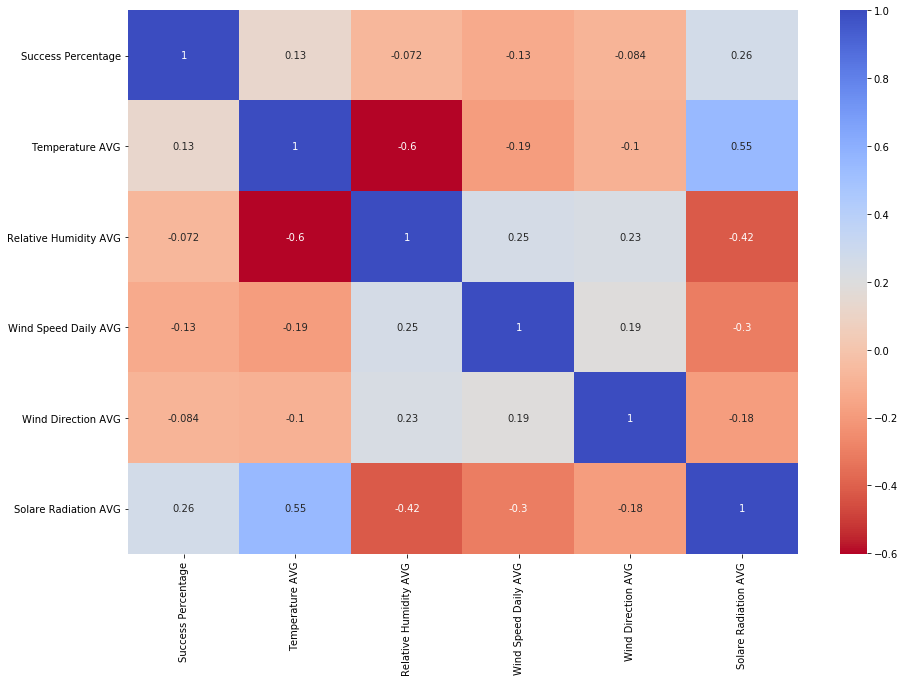

In [33]:
# Correlation Coefficient Matrix Heatmap
correlation = joined_data.drop(columns=["Date", "Attempted","Succeeded", "Battery Voltage AVG"]).corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation, cmap="coolwarm_r", annot=True, xticklabels=correlation.columns.values, yticklabels=correlation.columns.values)

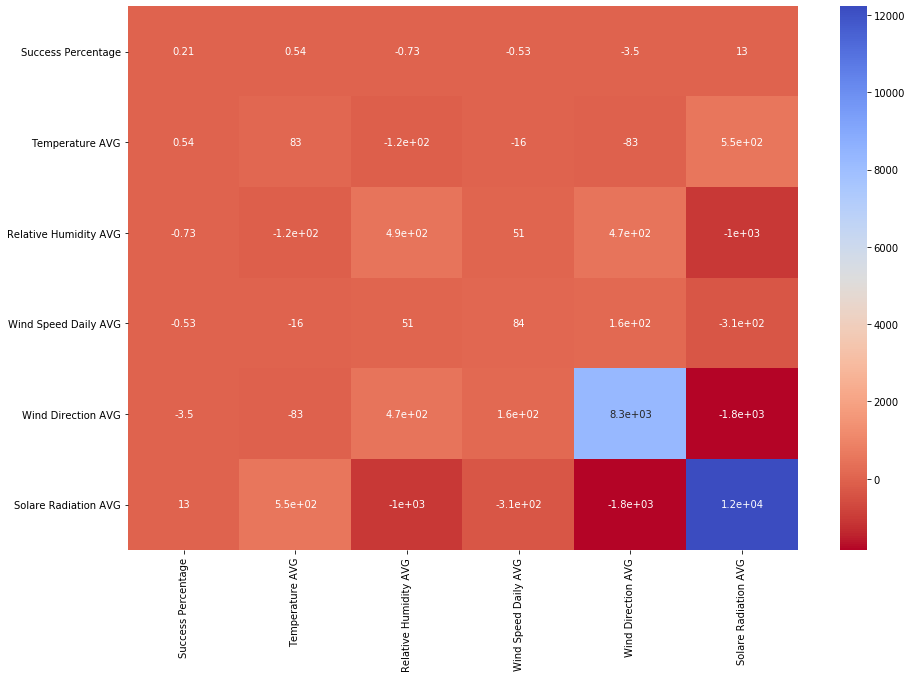

In [34]:
# Covariance Coefficient Matrix Heatmap
covariance = joined_data.drop(columns=["Date", "Attempted","Succeeded", "Battery Voltage AVG"]).cov()
plt.figure(figsize=(15, 10))
sns.heatmap(covariance, cmap="coolwarm_r", annot=True, xticklabels=covariance.columns.values, yticklabels=covariance.columns.values)

## Understand data with visualization

### Univariate plots to understand each individual attribute

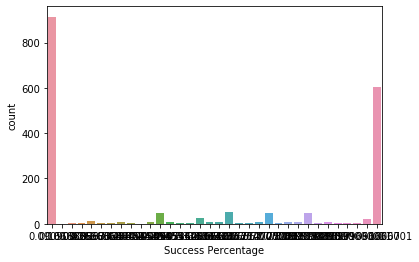

In [166]:
# Dependent variable -- 'Success Percentage'
sns.countplot(data['Success Percentage'])

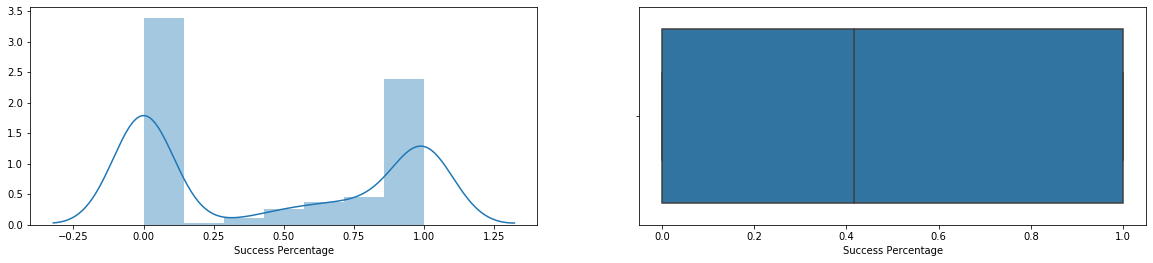

In [167]:
# Distribution of attribute -- "Success Percentage"
f = plt.figure(figsize=(20,4))
f.add_subplot(1,2,1)
sns.distplot(data['Success Percentage'])
f.add_subplot(1,2,2)
sns.boxplot(data['Success Percentage'])

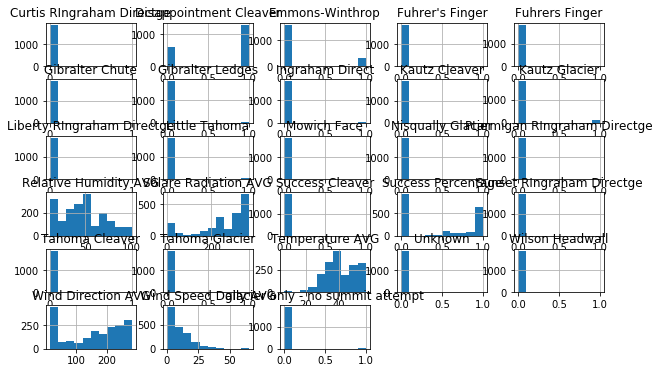

In [169]:
# histogram of all attributes
data.hist(figsize=(10,6), bins = 10)
plt.show()

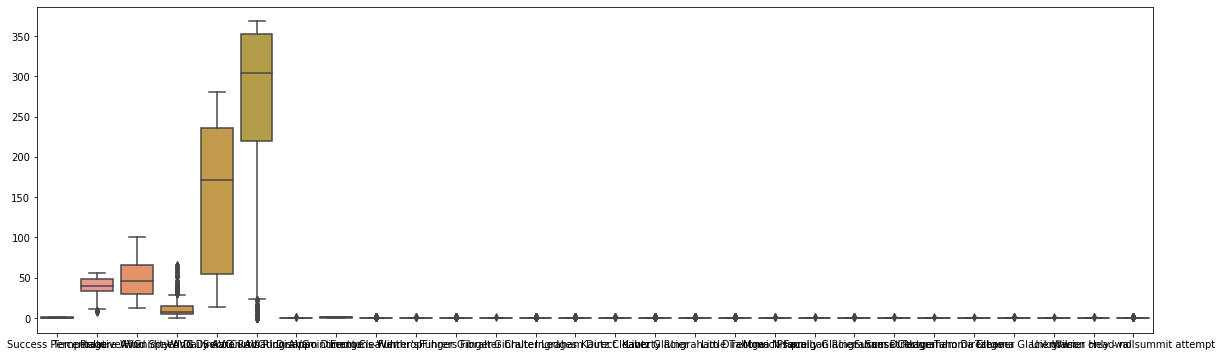

In [170]:
#box plot
plt.figure(figsize=(20,6))
sns.boxplot(data = data)

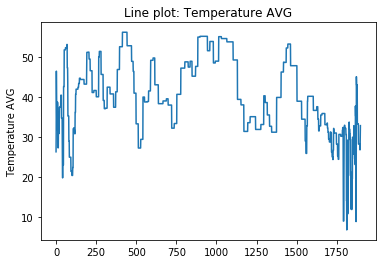

In [171]:
# Line plot
plt.plot(data['Temperature AVG'])
plt.title('Line plot: Temperature AVG')
plt.ylabel('Temperature AVG')
plt.show()

### Multivariate plots to understand relationship between attributes

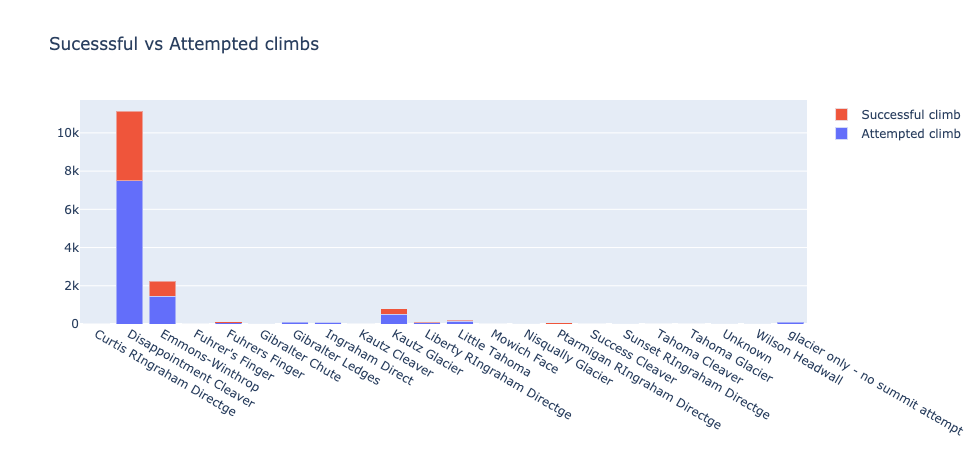

In [172]:
# Visualize succeeded vs attempted climbs per route
data.loc[joined_data["Succeeded"]==1]

# create succeeded climbs dataset
succeded_data = joined_data[["Route","Succeeded"]].groupby("Route").sum().reset_index()
succeded_data.columns = ["Route", "Succeeded"]
#succeded_data.head()

# create attempted climbs dataset
attempts_data = joined_data[["Route","Attempted"]].groupby("Route").sum().reset_index()
attempts_data.columns=["Route", "Attempted"]
#attempts_data.head()

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

SuccessAttempt_data = [go.Bar(x=attempts_data.Route,
               y=attempts_data.Attempted, name = "Attempted climb"),
        go.Bar(x=succeded_data.Route,
               y=succeded_data.Succeeded, name = 'Successful climb'),]

layout = go.Layout(barmode='stack', title = 'Sucesssful vs Attempted climbs')

fig = go.Figure(data=SuccessAttempt_data, layout=layout)
iplot(fig)

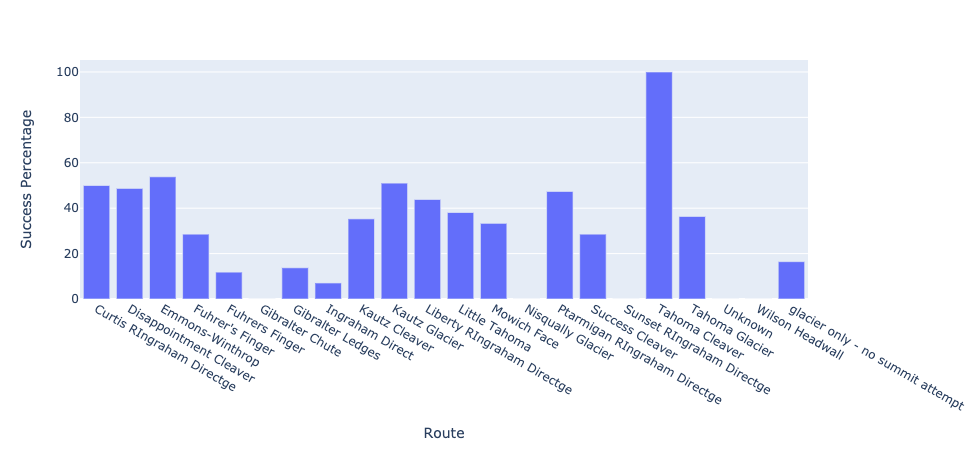

In [173]:
# Visualize % succeess rate per route
success_rate_data = pd.merge(attempts_data, succeded_data, how="left", on=["Route"])
success_rate_data["Success Percentage"] = (success_rate_data.Succeeded / success_rate_data.Attempted * 100)
#success_rate_data.head(10)

import plotly.express as px
fig = px.bar(success_rate_data, x = "Route", y = "Success Percentage")
fig.show()

In the Correlation Matrix above, we could see a positive correlation between success percentage + temperature + solar radiation. Let's see if this is a correlation throughout the year.

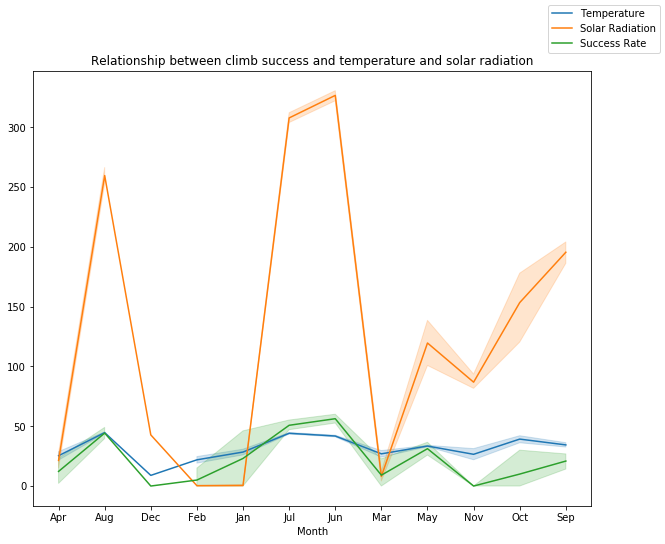

In [79]:
# Add Month
import calendar

joined_data["Date"] = pd.to_datetime(joined_data["Date"])
joined_data["Month"] = 0
joined_data["Month"] = joined_data["Date"].dt.month
joined_data.Month = joined_data.Month.apply(lambda x: calendar.month_abbr[x])
joined_data.head()

# Let's see what temperature has to do with success rate
f, ax = plt.subplots(1, 1, figsize=(10, 8))

joined_data["Success_Percentage"] = joined_data["Success Percentage"] * 100

sns.lineplot(x="Month", y="Temperature AVG", data=joined_data, ax=ax)
sns.lineplot(x="Month", y="Solare Radiation AVG", data=joined_data, ax=ax)
sns.lineplot(x=joined_data["Month"], y="Success_Percentage", data=joined_data, ax=ax)

ax.set_ylabel("")
f.legend(labels=["Temperature", "Solar Radiation", "Success Rate"])
plt.title('Relationship between climb success and temperature and solar radiation')
plt.show()

In the Correlation Matrix above, we could also see a negative correlation between success percentage + wind speed. Let's see if this is a correlation throughout the year.

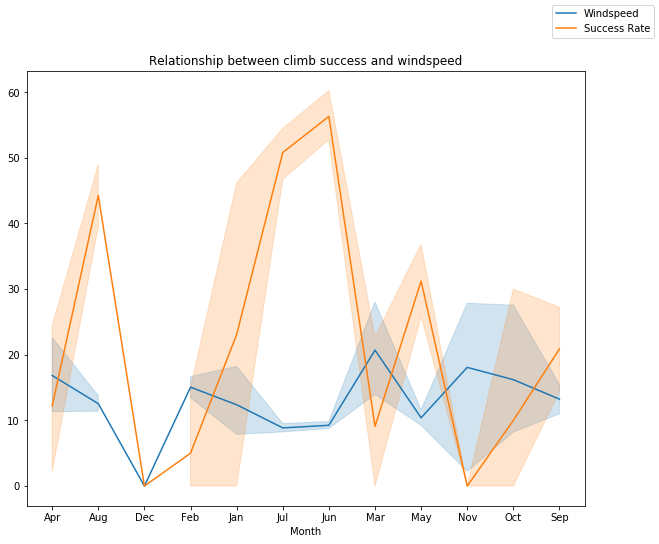

In [75]:
# Let's see what temperature has to do with success rate
f, ax = plt.subplots(1, 1, figsize=(10, 8))

joined_data["Success_Percentage"] = joined_data["Success Percentage"] * 100

sns.lineplot(x="Month", y="Wind Speed Daily AVG", data=joined_data, ax=ax)
sns.lineplot(x=joined_data["Month"], y="Success_Percentage", data=joined_data, ax=ax)

ax.set_ylabel("")
f.legend(labels=["Windspeed", "Success Rate"])
plt.title('Relationship between climb success and windspeed')
plt.show()

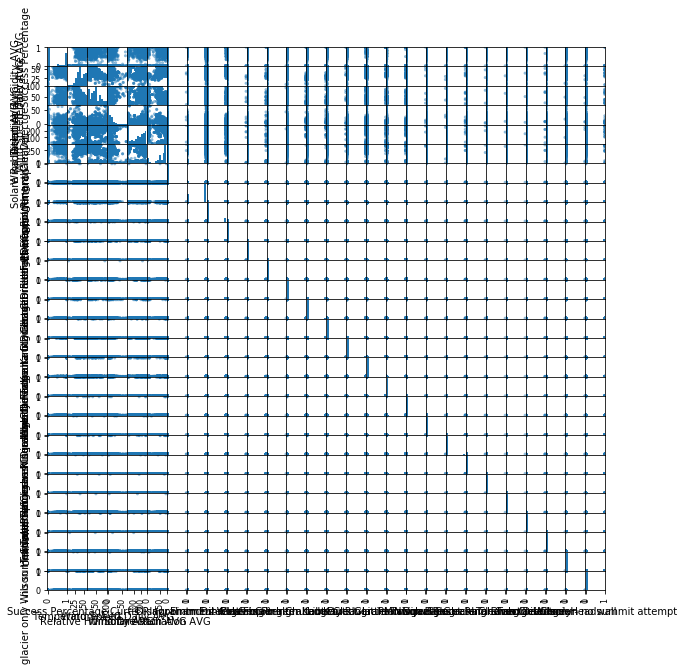

In [175]:
# scatter plot matrix
scatter_matrix(data, figsize=(10, 10))
plt.show()

---

# Modeling

**5 Levels of ML Model Iteration:**
1. Fitting Parameters
2. Tuning Hyperparameters
3. Feature Engineering

---

**Model Types**

**- Linear models:**
* Logistic Regression (LR)
* Linear Discriminant Analysis (LDA)

**- Nonlinear models:**
* K-Nearest Neighbors (KNN)
* Classification and Regression Trees (CART)
* Gaussian Naive Bayes (NB)
* Support Vector Machines (SVM)
* Ridge Regression (RR)

**- Bagging ensemble models:**
* Random Forest (RF)

---

Split dataset into train/test set:

In [35]:
# Create x (independent, input) + y (dependent, output) variables
x = data.drop(columns=['Success Percentage'])
y = data['Success Percentage']

# Split train/validation datasets (80-20%)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=7)

# dimensions of train/test set
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1511, 27) (1511,)
(378, 27) (378,)


## Iteration (1)

In [36]:
# Prepare models
models = []

# classification
#models.append(('KNN', KNeighborsClassifier()))
#models.append(('CART', DecisionTreeClassifier()))
#models.append(('SVM', SVC(gamma='auto')))
#models.append(('RF', RandomForestClassifier(n_estimators=100, max_features=3)))
#models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
#models.append(('LDA', LinearDiscriminantAnalysis()))
#models.append(('NB', GaussianNB()))

# regression
models.append(('RFregressor', RandomForestRegressor()))
models.append(('SVR', SVR()))
models.append(('KNNregressor', KNeighborsRegressor()))
models.append(('LinearR', LinearRegression()))

### Optimize Models by Fitting Parameters (1)

Train models on train set to find the best parameters with cross validation & get the first performance measures on the validation set

Find different model performance metrics part of *scikit learn* here: https://scikit-learn.org/stable/modules/model_evaluation.html

Cross Validation Score: RMSE & SD
RFregressor: 0.454 (0.017)
SVR: 0.465 (0.024)
KNNregressor: 0.471 (0.015)
LinearR: 0.441 (0.013)


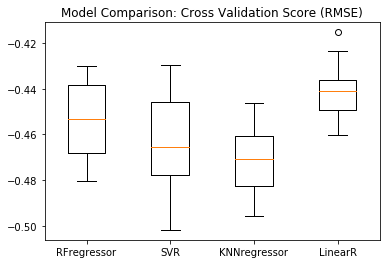

In [37]:
# Evaluate each model's accuracy on the validation set
print('Cross Validation Score: RMSE & SD')
results = []
names = []
for name, model in models:
	kfold = KFold(n_splits=10, random_state=7, shuffle=True)
	cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='neg_root_mean_squared_error')
	results.append(cv_results)
	names.append(name)
	print('%s: %.3f (%.3f)' % (name, -cv_results.mean(), cv_results.std()))
    
# Visualize model comparison
plt.boxplot(results, labels=names)
plt.title('Model Comparison: Cross Validation Score (RMSE)')
plt.show()

### Evaluate Model Performance (1)

Performance metrics on ***train set***:

In [179]:
print('Train Set Performance Metrics: RMSE & MAE')
for name, model in models:
    trained_model = model.fit(x_train, y_train)
    y_train_pred = trained_model.predict(x_train)
    print('%s: %.3f (%.3f)' % (name, sqrt(mean_squared_error(y_train, y_train_pred)), (mean_absolute_error(y_train, y_train_pred))))

Train Set Performance Metrics: RMSE & MAE
RFregressor: 0.364 (0.297)
SVR: 0.460 (0.384)
KNNregressor: 0.408 (0.337)
LinearR: 0.434 (0.400)


Performance metrics on ***test set***:

In [180]:
print('Test Set Performance Metrics: RMSE & MAE')
for name, model in models:
    trained_model = model.fit(x_train, y_train)
    y_test_pred = trained_model.predict(x_test)
    print('%s: %.3f (%.3f)' % (name, sqrt(mean_squared_error(y_test, y_test_pred)), (mean_absolute_error(y_test, y_test_pred))))

Test Set Performance Metrics: RMSE & MAE
RFregressor: 0.441 (0.373)
SVR: 0.478 (0.401)
KNNregressor: 0.467 (0.392)
LinearR: 0.449 (0.412)


#### *EXTRA: deep error check on individual model*

In [182]:
# Train model
RFregressor = RandomForestRegressor().fit(x_train, y_train)


# Predict y on train set
y_train_pred = RFregressor.predict(x_train)

# Train set performance metrics
print('Train Set Performance Metrics: RMSE')
print('%.3f' % (sqrt(mean_squared_error(y_train, y_train_pred))))

# Predict y on test set
y_test_pred = RFregressor.predict(x_test)

# Test set performance metrics
print('Train Set Performance Metrics: RMSE')
print('%.3f' % (sqrt(mean_squared_error(y_test, y_test_pred))))

Train Set Performance Metrics: RMSE
0.364
Train Set Performance Metrics: RMSE
0.439


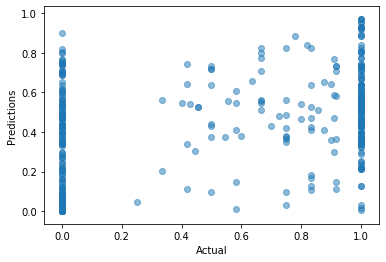

In [183]:
# Visualize predicted vs actual mountain climb 'Success Percentage' -- if perfect, then a diagonal line
plt.scatter(y_test, y_test_pred, alpha = 0.5)
plt.xlabel('Actual')
plt.ylabel('Predictions')
plt.show()

## Iteration (2)

### Preprocess Data (2)
#### Normalization (Min-Max)

In [184]:
# Min-Max norm all features
minmax_scaler = MinMaxScaler()
x_norm = minmax_scaler.fit_transform(x)
x = pd.DataFrame(x_norm, columns=x.columns)
x.head()

,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solare Radiation AVG,Curtis RIngraham Directge,Disappointment Cleaver,Emmons-Winthrop,Fuhrer's Finger,Fuhrers Finger,...,Mowich Face,Nisqually Glacier,Ptarmigan RIngraham Directge,Success Cleaver,Sunset RIngraham Directge,Tahoma Cleaver,Tahoma Glacier,Unknown,Wilson Headwall,glacier only - no summit attempt
0,0.395119,0.083886,0.427392,0.204255,0.240442,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.496061,0.106431,0.034478,0.389892,0.254473,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.803203,0.169424,0.263495,0.920335,0.375994,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.692326,0.182255,0.300762,0.997736,0.479228,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.637191,0.707076,1.000000,0.941191,0.075508,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Split *rescaled* dataset into train/test set:

In [185]:
# Split train/validation datasets (80-20%)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=7)

# dimensions of train/test set
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1511, 27) (1511,)
(378, 27) (378,)


### Optimize Models by Fitting Parameters (2)

Cross Validation Score: RMSE & SD
RFregressor: 0.452 (0.018)
SVR: 0.465 (0.025)
KNNregressor: 0.469 (0.021)
LinearR: 0.441 (0.013)


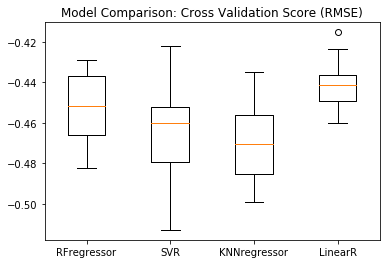

In [186]:
# Evaluate each model's accuracy on the validation set
print('Cross Validation Score: RMSE & SD')
results = []
names = []
for name, model in models:
	kfold = KFold(n_splits=10, random_state=7, shuffle=True)
	cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='neg_root_mean_squared_error')
	results.append(cv_results)
	names.append(name)
	print('%s: %.3f (%.3f)' % (name, -cv_results.mean(), cv_results.std()))
    
# Visualize model comparison
plt.boxplot(results, labels=names)
plt.title('Model Comparison: Cross Validation Score (RMSE)')
plt.show()

### Evaluate Model Performance (2)

Performance metrics on ***train set***:

In [187]:
print('Train Set Performance Metrics: RMSE & MAE')
for name, model in models:
    trained_model = model.fit(x_train, y_train)
    y_train_pred = trained_model.predict(x_train)
    print('%s: %.3f (%.3f)' % (name, sqrt(mean_squared_error(y_train, y_train_pred)), (mean_absolute_error(y_train, y_train_pred))))

Train Set Performance Metrics: RMSE & MAE
RFregressor: 0.364 (0.298)
SVR: 0.447 (0.368)
KNNregressor: 0.405 (0.336)
LinearR: 0.434 (0.400)


Performance metrics on ***test set***:

In [188]:
print('Test Set Performance Metrics: RMSE & MAE')
for name, model in models:
    trained_model = model.fit(x_train, y_train)
    y_test_pred = trained_model.predict(x_test)
    print('%s: %.3f (%.3f)' % (name, sqrt(mean_squared_error(y_test, y_test_pred)), (mean_absolute_error(y_test, y_test_pred))))

Test Set Performance Metrics: RMSE & MAE
RFregressor: 0.439 (0.371)
SVR: 0.477 (0.400)
KNNregressor: 0.464 (0.389)
LinearR: 0.449 (0.412)


#### *EXTRA: deep error check on individual model*

In [189]:
# Train model
RFregressor = RandomForestRegressor().fit(x_train, y_train)


# Predict y on train set
y_train_pred = RFregressor.predict(x_train)

# Train set performance metrics
print('Train Set Performance Metrics: RMSE')
print('%.3f' % (sqrt(mean_squared_error(y_train, y_train_pred))))

# Predict y on test set
y_test_pred = RFregressor.predict(x_test)

# Test set performance metrics
print('Train Set Performance Metrics: RMSE')
print('%.3f' % (sqrt(mean_squared_error(y_test, y_test_pred))))

Train Set Performance Metrics: RMSE
0.364
Train Set Performance Metrics: RMSE
0.436


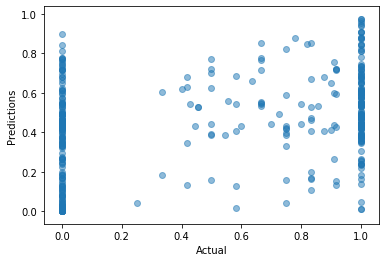

In [191]:
# Visualize predicted vs actual mountain climb 'Success Percentage' -- if perfect, then a diagonal line
plt.scatter(y_test, y_test_pred, alpha = 0.5)
plt.xlabel('Actual')
plt.ylabel('Predictions')
plt.show()

## Iteration (3)

### Preprocess Data (3)

**Add *'Month'* as an independent variable (x; feature; column).**

In [84]:
# Feature selection
data = joined_data.drop(columns=["Date", "Attempted","Succeeded", "Battery Voltage AVG", "Success_Percentage"])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1889 entries, 0 to 1897
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Route                  1889 non-null   object 
 1   Success Percentage     1889 non-null   float64
 2   Temperature AVG        1889 non-null   float64
 3   Relative Humidity AVG  1889 non-null   float64
 4   Wind Speed Daily AVG   1889 non-null   float64
 5   Wind Direction AVG     1889 non-null   float64
 6   Solare Radiation AVG   1889 non-null   float64
 7   Month                  1889 non-null   object 
dtypes: float64(6), object(2)
memory usage: 132.8+ KB


In [88]:
# dummify "Route"
dummy_Route = pd.get_dummies(data['Route'])
dummify_data = pd.concat([data, dummy_Route], axis = 1)
data = dummify_data.drop(columns=["Route"])

KeyError: 'Route'

In [89]:
# dummify "Month"
dummy_Month = pd.get_dummies(data['Month'])
dummifyMonth_data = pd.concat([data, dummy_Month], axis = 1)
data = dummifyMonth_data.drop(columns=["Month"])

KeyError: 'Month'

Split dataset into train/test set:

In [94]:
# Create x (independent, input) + y (dependent, output) variables
x = data.drop(columns=['Success Percentage'])
y = data['Success Percentage']

**Feature Scaling: Normalization**

In [96]:
# Min-Max norm all features
minmax_scaler = MinMaxScaler()
x_norm = minmax_scaler.fit_transform(x)
x = pd.DataFrame(x_norm, columns=x.columns)
x.describe()

,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solare Radiation AVG,Curtis RIngraham Directge,Disappointment Cleaver,Emmons-Winthrop,Fuhrer's Finger,Fuhrers Finger,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
count,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,...,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000,1889.000000
mean,0.686870,0.405155,0.161021,0.532115,0.710351,0.001059,0.682372,0.155638,0.002647,0.014293,...,0.000529,0.010588,0.006882,0.283748,0.309158,0.011646,0.115405,0.001588,0.005294,0.066173
std,0.184815,0.252836,0.140343,0.341317,0.300399,0.032530,0.465677,0.362608,0.051394,0.118728,...,0.023008,0.102377,0.082693,0.450935,0.462269,0.107317,0.319595,0.039830,0.072585,0.248649
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.538167,0.201897,0.067707,0.156283,0.598237,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.673460,0.385421,0.111684,0.592534,0.827607,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.847422,0.602610,0.225027,0.831818,0.956303,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Split *rescaled* dataset into train/test set:

In [103]:
# Split train/validation datasets (80-20%)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=7)

# dimensions of train/test set
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1511, 39) (1511,)
(378, 39) (378,)


### Optimize Models by Fitting Parameters (3)

Cross Validation Score: RMSE & SD
RFregressor: 0.452 (0.017)
SVR: 0.465 (0.029)
KNNregressor: 0.463 (0.024)
LinearR: 0.438 (0.016)


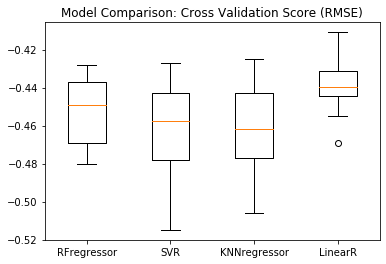

In [104]:
# Evaluate each model's accuracy on the validation set
print('Cross Validation Score: RMSE & SD')
results = []
names = []
for name, model in models:
	kfold = KFold(n_splits=10, random_state=7, shuffle=True)
	cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='neg_root_mean_squared_error')
	results.append(cv_results)
	names.append(name)
	print('%s: %.3f (%.3f)' % (name, -cv_results.mean(), cv_results.std()))
    
# Visualize model comparison
plt.boxplot(results, labels=names)
plt.title('Model Comparison: Cross Validation Score (RMSE)')
plt.show()

### Evaluate Model Performance (3)

Performance metrics on ***train set***:

In [105]:
print('Train Set Performance Metrics: RMSE & MAE')
for name, model in models:
    trained_model = model.fit(x_train, y_train)
    y_train_pred = trained_model.predict(x_train)
    print('%s: %.3f (%.3f)' % (name, sqrt(mean_squared_error(y_train, y_train_pred)), (mean_absolute_error(y_train, y_train_pred))))

Train Set Performance Metrics: RMSE & MAE
RFregressor: 0.364 (0.298)
SVR: 0.433 (0.349)
KNNregressor: 0.407 (0.328)
LinearR: 0.430 (0.392)


Performance metrics on ***test set***:

In [106]:
print('Test Set Performance Metrics: RMSE & MAE')
for name, model in models:
    trained_model = model.fit(x_train, y_train)
    y_test_pred = trained_model.predict(x_test)
    print('%s: %.3f (%.3f)' % (name, sqrt(mean_squared_error(y_test, y_test_pred)), (mean_absolute_error(y_test, y_test_pred))))

Test Set Performance Metrics: RMSE & MAE
RFregressor: 0.438 (0.371)
SVR: 0.457 (0.378)
KNNregressor: 0.463 (0.380)
LinearR: 0.444 (0.402)


#### *EXTRA: deep error check on individual model*

In [107]:
# Train model
RFregressor = RandomForestRegressor().fit(x_train, y_train)


# Predict y on train set
y_train_pred = RFregressor.predict(x_train)

# Train set performance metrics
print('Train Set Performance Metrics: RMSE')
print('%.3f' % (sqrt(mean_squared_error(y_train, y_train_pred))))

# Predict y on test set
y_test_pred = RFregressor.predict(x_test)

# Test set performance metrics
print('Train Set Performance Metrics: RMSE')
print('%.3f' % (sqrt(mean_squared_error(y_test, y_test_pred))))

Train Set Performance Metrics: RMSE
0.364
Train Set Performance Metrics: RMSE
0.439


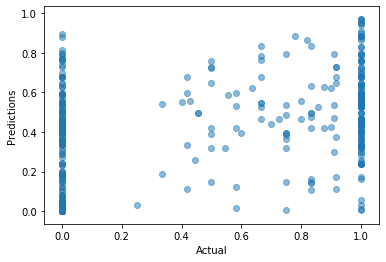

In [108]:
# Visualize predicted vs actual mountain climb 'Success Percentage' -- if perfect, then a diagonal line
plt.scatter(y_test, y_test_pred, alpha = 0.5)
plt.xlabel('Actual')
plt.ylabel('Predictions')
plt.show()

## Iteration (4)

### Optimize Models by Tuning Hyperparameters (4)

Random Forest Regressor had the best metrics in previous iterations, therefore let's only tune the hyperparameters for this one model.

In [109]:
# Random Forest Regressor (RFregressor)
#Create dictionary of hyperparameters that we want to tune
RFR_params = {
    'bootstrap': [True],
    'max_depth': [90, 100, 110, 120],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [2, 3, 4, 5],
    'min_samples_split': [6, 8, 10, 12],
    'n_estimators': [50, 100, 200, 300, 1000]
}

# Create new RandomForestRegressor object using GridSearch
grid_RFR = GridSearchCV(RandomForestRegressor(), RFR_params, cv=3)

#Fit the model
best_model_RFR = grid_RFR.fit(x_train, y_train)

# Print the value of best hyperparameters
#print('Best n_neighbors:', best_model_RFR.best_estimator_.get_params()['n_neighbors'])
#print('Best n_neighbors:', best_model_RFR.best_estimator_.get_params()['weights'])
#print('Best n_neighbors:', best_model_RFR.best_estimator_.get_params()['metric'])
#print('Best leaf_size:', best_model_RFR.best_estimator_.get_params()['leaf_size'])
#print('Best p:', best_model_RFR.best_estimator_.get_params()['p'])
print(best_model_RFR.best_params_)

{'bootstrap': True, 'max_depth': 120, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 12, 'n_estimators': 50}


### Evaluate Model Performance (4)

In [110]:
# Predict y on train set
y_train_pred_2 = best_model_RFR.predict(x_train)

# Train set performance metrics
print('Train Set Performance Metrics: RMSE')
print('%.3f' % (sqrt(mean_squared_error(y_train, y_train_pred_2))))

# Predict y on test set
y_test_pred_2 = best_model_RFR.predict(x_test)

# Test set performance metrics
print('Train Set Performance Metrics: RMSE')
print('%.3f' % (sqrt(mean_squared_error(y_test, y_test_pred_2))))

Train Set Performance Metrics: RMSE
0.403
Train Set Performance Metrics: RMSE
0.433


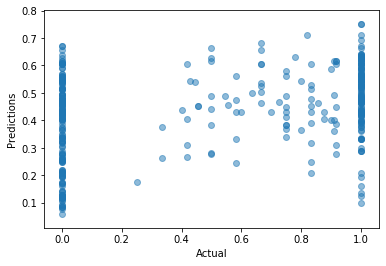

In [111]:
# Visualize predicted vs actual mountain climb 'Success Percentage' -- if perfect, then a diagonal line
plt.scatter(y_test, y_test_pred_2, alpha = 0.5)
plt.xlabel('Actual')
plt.ylabel('Predictions')
plt.show()

# Save final model

In [201]:
# Save model to disk
FinalModel_RandomForestRegressor = 'FinalModel.sav'
pickle.dump(best_model_RFR, open(FinalModel_RandomForestRegressor, 'wb'))

**Final Notes**
* The best model was Random Forest Regressor. 
* We dummified the Route, normalized the features, tuned parameters and hyperparamters.
* The RMSE of the model's performance in predicting the % successf rate of reaching the peak of Mt Rainier was only improved from 0.439 to 0.433. The dataset is too small (1889 total rows) for room for extensive further optimization and tuning and improvements. 
* In the future, we could try with a much larger dataset